# Tutorial 3 - Trace Elements
Simon Matthews (University of Iceland) and Kevin Wong (University of Leeds)

## Introduction

PyMelt contains a chemistry module for calculating the trace element composition of melts. There are a number of inbuilt chemical methods:
- Batch melting
- Continuous melting, which can be used to calculate either instantaneous or accumulated melts
- INVMEL, following McKenzie & O'Nions (1991), incorporates the effect of aluminous phase transitions and phase exhaustion
Currently the methods all use constant partition coefficients, but soon using pressure and temperature dependent partition coeffients will be an option.

The module is designed to allow maximum customisation of the calculations, but using the default options is very straightforward. INVMEL is used for most elements by default, with the exception of the most incompatible elements, which are modelled assuming continuous melting with 0.5% porosity. See the documentation for more information about the partition coefficients used.

First we must import the required modules:

In [105]:
import pyMelt as m
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from copy import copy

## Making MORB from a homogeneous mantle
In the first example we will predict the composition of a spreading centre basalt using the default options.

First we must create a `mantle` object and perform adiabatic melting, as before:

In [106]:
lz = m.lithologies.matthews.klb1()
mantle = m.mantle([lz], [1.0], ['lz'])
column = mantle.adiabaticMelt(1350.0)

We must now add chemistry to these melts. The default options are designed for melting depleted mantle, so we don't need to set up or pass any additional arguments:

In [107]:
column.calculateChemistry()

Lithology composition is set to the depleted mantle of Workman & Hart (2005).


Notice that pyMelt told us it was setting the composition to the depleted mantle of Workman & Hart (2005). See below for how to adjust this. At this point we can already inspect some of the instantaneous results:

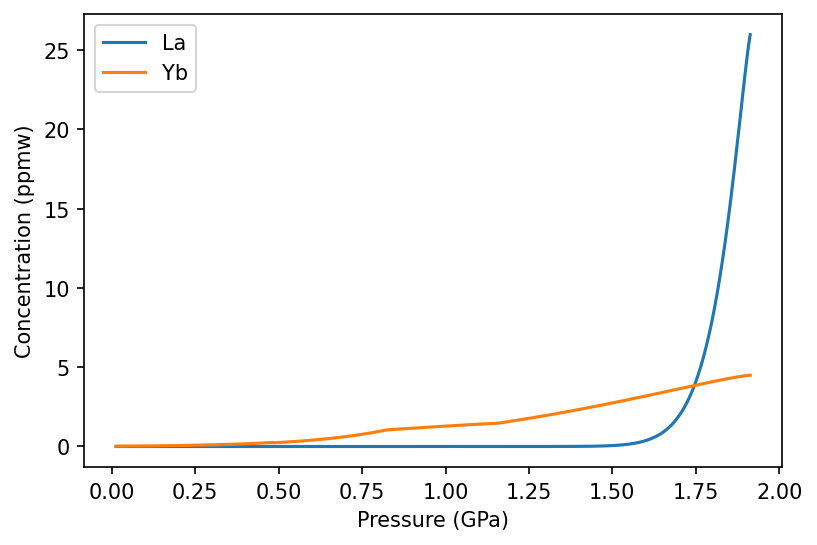

In [108]:
f, a = plt.subplots(dpi=150)
a.plot(column.P, column.lithologies['lz']['La'], label='La')
a.plot(column.P, column.lithologies['lz']['Yb'], label='Yb')

a.set_ylabel('Concentration (ppmw)')
a.set_xlabel('Pressure (GPa)')
a.legend()
plt.show()

Notice how Yb behaves more compatibly than La, persisting for much longer in melts. The subtle change in gradient in the Yb line occurs during the spinel to plagioclase transition.

If you want to calculate specific elements only then we must specify them and their concentrations:

In [109]:
column_Tb_Yb = mantle.adiabaticMelt(1350)
column_Tb_Yb.calculateChemistry(
    {'lz': {
        'Tb': 0.07,
        'Yb': 0.365
           }})

Here we use Tb and Yb, which are two elements often used to resolve depth of melting. We can calculate the ratio between these elements and see how they change with pressure in generated melts:

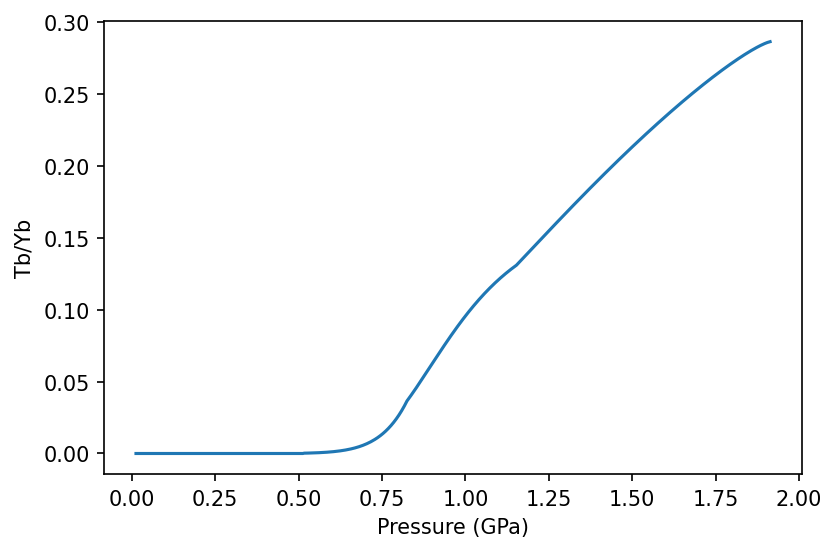

In [110]:
Tb_Yb = [i/j for i,j in zip(column_Tb_Yb.lithologies['lz']['Tb'], column_Tb_Yb.lithologies['lz']['Yb'])]
f, a = plt.subplots(dpi=150)
a.plot(column_Tb_Yb.P, Tb_Yb)
a.set_ylabel('Tb/Yb')
a.set_xlabel('Pressure (GPa)')
plt.show()

When the `spreadingCentre` `geoSetting` class is created pyMelt automatically calculates the crustal thickness based on a triangular melting region with passive upwelling (as shown in Tutorial 1). If the `MeltingColumn` class contains chemistry, creating the `geoSetting` class also applies the appropriate homogenisation calculation. For a spreading centre this is homogenisation with a triangular weighting.

In [111]:
morb = m.geosettings.spreadingCentre(column)

We can view the raw homogenised trace element concentrations:

In [112]:
morb.chemistry

Rb       0.396402
Ba       4.461680
Th       0.062105
U        0.025326
Nb       1.175840
Ta       0.076009
La       1.472224
Ce       4.086621
Pb       0.141986
Pr       0.759662
Nd       3.912036
Sr      56.729217
Zr      35.946303
Hf       0.958393
Sm       1.454836
Eu       0.565583
Ti    3903.085077
Gd       2.100972
Tb       0.394838
Dy       2.861796
Ho       0.642118
Y       18.186917
Er       1.912909
Yb       1.972800
Lu       0.309258
dtype: float64

What about the case where we considered only two elements?

In [113]:
morb_Tb_Yb = m.geosettings.spreadingCentre(column_Tb_Yb)
morb_Tb_Yb.chemistry

Tb    0.394838
Yb    1.972800
dtype: float64

In this case we have homogenised only the two elements that calculations have been performed on.

To really make sense of results in which we have multiple elements it is convenient to make a spider diagram, for which the `GeoSetting` classes have a built in method. There are many ways to customise the plot, most importantly the reference values used for normalisation. The default normalisation is the primitive mantle of Palme & O'Neill (2013).

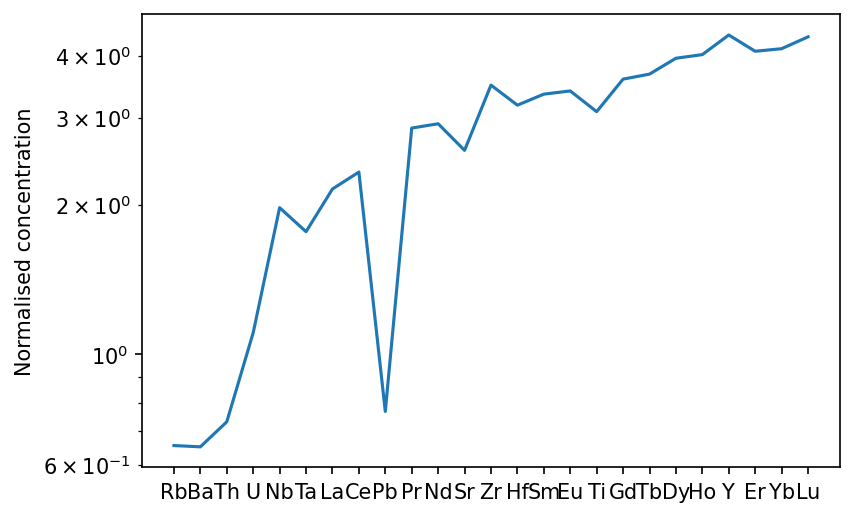

In [114]:
f,a = morb.plotSpider()
plt.show()

If we wanted to see just the rare earth elements, we can specify this. We can also normalise to chondrite, and show the range of instantaneous melts:

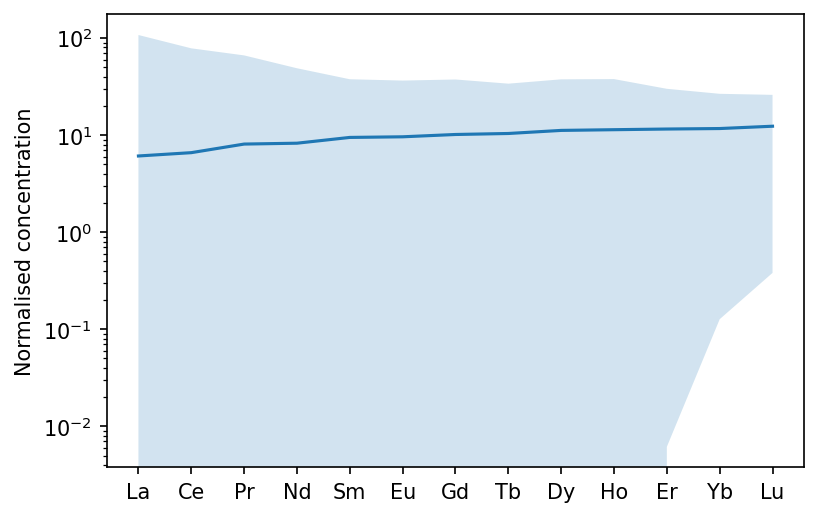

In [115]:
f,a = morb.plotSpider(element_order=['La','Ce','Pr','Nd','Sm','Eu','Gd','Tb','Dy','Ho','Er','Yb','Lu'], 
                       normalisation='CI', plot_instantaneous=True)
plt.show()

Finally, we can see what the effect of some crystal fractionation would be on the composition. This time I will normalise to depleted mantle, to remove the Pb anomaly. You can also change the axis labels (to specify the normalisation, for example), as shown here.

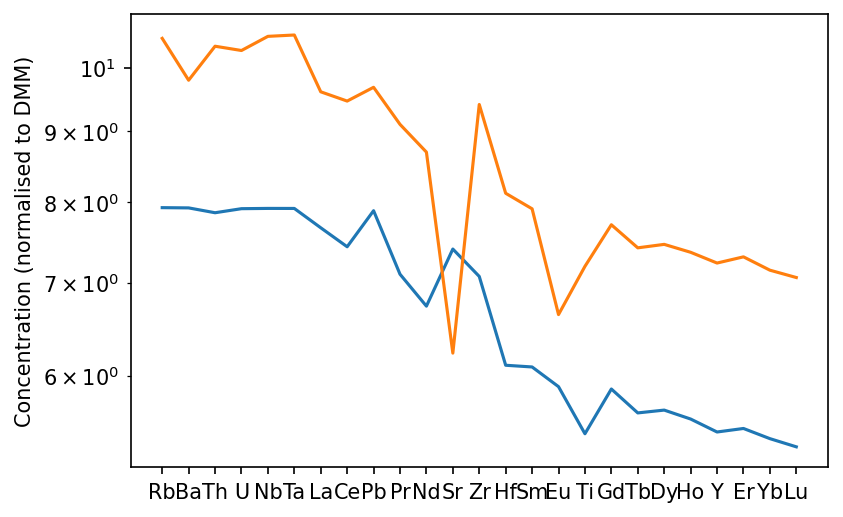

In [116]:
f,a = morb.plotSpider(normalisation='DM', crystal_fraction={'olv':0.05, 'plg':0.2})
a.set_ylabel("Concentration (normalised to DMM)")
plt.show()

Crystallising olivine and plagioclase has enriched the melt in trace elements, with the exception of Sr, since it is very compatible in plagioclase. Eu also shows a negative anomaly owing also to its relative compatibility in plagioclase. The crystallisation calculation can also be used independently of plotting. In fact the plotting method just calls the `GeoSetting.crystallisation_chemistry()` itself. See the documentation for `GeoSetting.crystallisation_chemistry()` for information about customising the crystallisation calculation.

## Making OIB from a heterogeneous mantle
In addition to calculating the trace element concentrations in melts from a homogeneous mantle, pyMelt allows the trace element contents of melts from multiple lithologies to be calculated simultaneously. However, pyMelt requires additional input to tell it how to treat each individual lithology. This is partly from a practical stand point- one set of default options for pyroxenite (for example) is unlikely to be relevant to many calculations.

Like before we start by setting up a mantle and melting it by adiabatic decompression. We will consider a three component mantle made up of lherzolite, pyroxenite, and non-melting harzburgite.

In [117]:
px = m.lithologies.matthews.kg1()
hz = m.lithologies.shorttle.harzburgite()
mantle = m.mantle([lz, px, hz], [0.6, 0.1, 0.3], ['lz','px','hz'])
oi_col = mantle.adiabaticMelt(1480.0)

C:\Users\user\anaconda3\lib\site-packages\pyMelt\mantle_class.py:488: UserWarning: Freezing prevented.
  _warn("Freezing prevented.")


Notice that pyMelt warned us that freezing was prevented. This can happen when the pyroxenite melting extracts sufficient heat that the partially-molten lherzolite will begin to freeze. When we are using the model to approximate fractional melt extraction we do not want this to happen, and so by default pyMelt will not allow freezing to occur.

PyMelt has some published mantle compositions built in, for example the subducted oceanic crust composition calculated by Stracke et al. (2003):

In [118]:
m.chemistry.stracke03_bsic

{'Rb': 0.57,
 'Ba': 6.59,
 'Th': 0.088,
 'U': 0.027,
 'Nb': 1.95,
 'Ta': 0.124,
 'La': 1.68,
 'Ce': 5.89,
 'Pb': 0.09,
 'Nd': 7.45,
 'Sr': 81.0,
 'Zr': 64.0,
 'Hf': 1.78,
 'Sm': 2.69,
 'Eu': 1.04,
 'Ti': 7735.0,
 'Gd': 4.03,
 'Dy': 5.01,
 'Y': 28.5,
 'Er': 3.13,
 'Yb': 2.99,
 'Lu': 0.45}

The KG1 bulk composition used as the pyroxenite endmember is a mixture of oceanic crust and lherzolite peridotite. We can mirror this in the trace elements by calculating a mix of the subducted crust composition and the depleted mantle composition. Note that the `dict` objects have to be converted to `pandas.Series` objects before applying mathematical operations, and then converted back before feeding to pyMelt.

In [119]:
kg1_tes = (0.333 * pd.Series(m.chemistry.stracke03_bsic) + 
           0.666 * pd.Series(m.chemistry.palme13_pm))
kg1_tes = kg1_tes[~np.isnan(kg1_tes)]
kg1_tes = dict(kg1_tes)
kg1_tes

{'Ba': 6.75657,
 'Ce': 3.1288014,
 'Dy': 2.1504474,
 'Er': 1.3542444,
 'Eu': 0.45720900000000003,
 'Gd': 1.7319330000000002,
 'Hf': 0.7934724000000001,
 'La': 1.0144512,
 'Lu': 0.19702278,
 'Nb': 1.04562,
 'Nd': 3.373956,
 'Pb': 0.15318,
 'Rb': 0.59274,
 'Sm': 1.1852802,
 'Sr': 41.625,
 'Ta': 0.06993,
 'Th': 0.0858474,
 'Ti': 3418.245,
 'U': 0.024242400000000004,
 'Y': 12.24108,
 'Yb': 1.3136184000000002,
 'Zr': 28.1718}

We now have to start setting up the chemistry calculation. We can use the default models again (which for most elements is invmel), but the parameters controlling invmels behaviour will be different for pyroxenite.

To see what parameters are required, we can look at the `invmelSpecies` object documentation:

In [120]:
m.chemistry.invmelSpecies?

Cpx (and grt) persists to much higher melt fractions during pyroxenite melting, though the melt fraction at cpx-exhaustion varies somewhat with pressure. Assuming exhaustion at 60% melting errs towards the low pressure results (it persists for longer at higher pressures)

In [121]:
cpxExhaustion = 0.6

For simplicity we will translate the spinel-out reaction from lherzolite to lower pressures for the pyroxenite, and use an identical line for garnet-in:

In [122]:
spinelOutCoeffs = [666.7, 50]
garnetInCoeffs = [666.7, 50]

We will not change the plagioclase-spinel interval (it is not so different between KG1 and KLB1).

Perhaps most importantly, we must change the proportions of mineral phases present. Fortunately, pyMelt has the mineral proportions for KG1 stored already in the chemistry module:

In [123]:
m.chemistry.kg1_MineralProportions

,olv,opx,cpx,grt,spn,plg
grt_field,0.181,0.012,0.422,0.385,0.000,0.000
spn_field,0.110,0.178,0.641,0.000,0.071,0.000
plg_field,0.118,0.150,0.655,0.000,0.000,0.067


We must then feed this information to the chemistry module. Notice that the parameters must be provided for each lithology (even the non-melting harzburgite!). I copied the values for lherzolite from the default values printed in the docstring above.

In [124]:
oi_col.calculateChemistry(elements = {'lz': m.chemistry.workman05_dmm,
                                       'px': kg1_tes,
                                       'hz': m.chemistry.workman05_dmm}, # Doesn't matter what value
                           cpxExhaustion = {'lz': 0.18,
                                            'px': cpxExhaustion,
                                            'hz': 0.1}, # Doesn't matter what value
                           garnetInCoeffs = {'lz': [666.7, 400.0],
                                             'px': garnetInCoeffs,
                                             'hz': [0,0]},
                           spinelOutCoeffs = {'lz': [666.7, 533.0],
                                              'px': spinelOutCoeffs,
                                              'hz': [0,0]}, # Doesn't matter what value
                           mineralProportions = {'lz': m.chemistry.klb1_MineralProportions,
                                                 'px': m.chemistry.kg1_MineralProportions,
                                                 'hz': m.chemistry.klb1_MineralProportions} # Doesn't matter what value
                          )

As before, we can view the instantaneous melts within the `MeltingColumn` object. Here we are comparing the two melting lithologies:

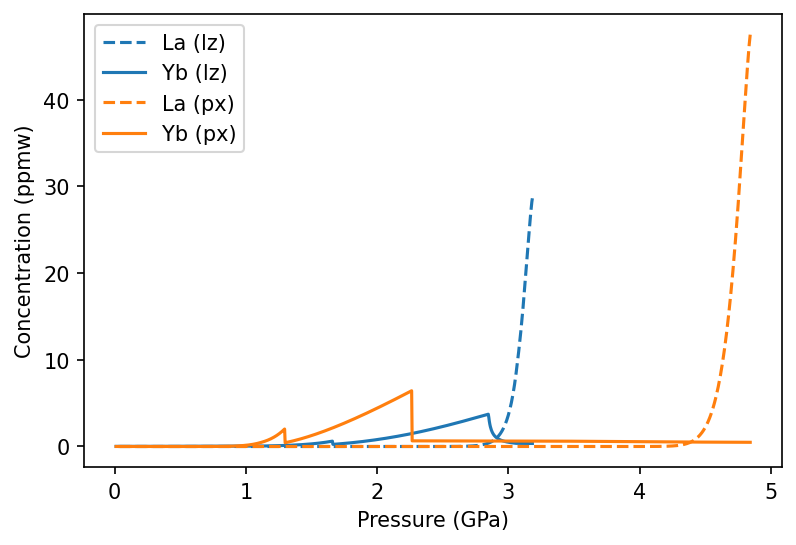

In [125]:
f, a = plt.subplots(dpi=150)
a.plot(oi_col.P, oi_col.lithologies['lz']['La'], label='La (lz)', ls='--', c='C0')
a.plot(oi_col.P, oi_col.lithologies['lz']['Yb'], label='Yb (lz)', ls='-', c='C0')

a.plot(oi_col.P, oi_col.lithologies['px']['La'], label='La (px)', ls='--', c='C1')
a.plot(oi_col.P, oi_col.lithologies['px']['Yb'], label='Yb (px)', ls='-', c='C1')

a.set_ylabel('Concentration (ppmw)')
a.set_xlabel('Pressure (GPa)')
a.legend()
plt.show()

To see the homogenised melt that would be erupted through thick lithosphere (1.5 GPa at the base in the example here), we can create an `IntraPlate` class. We will also apply a greater weighting to the deepest melts in the melting region, to simulate the effect of active upwelling fluxing more mantle through the base of the melting region.

In [126]:
oib = m.geosettings.intraPlate(oi_col, 2.5, weightingFunction=m.geosettings.weighting_expdecay, 
                               weighting_wavelength=0.1)

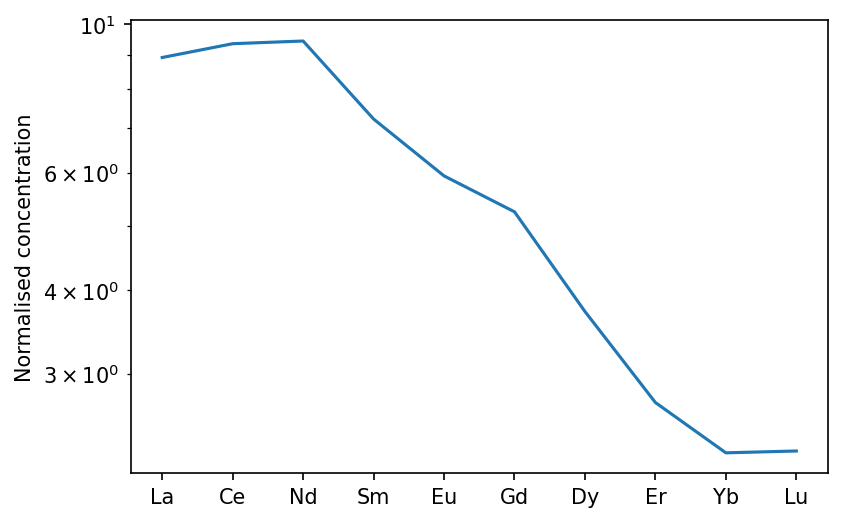

In [127]:
f,a = oib.plotSpider(element_order=['La','Ce','Nd','Sm','Eu','Gd','Dy','Er','Yb','Lu'])

## Changing parameters in the calculation
pyMelt allows you to change any of the parameters used in the calculation. You can set one parameter for every element in every lithology, or set each individually by nesting dictionaries (like the elements variable above). To illustrate this, we could change the olivine partition coefficient for La to make it very compatible.

First, we can obtain the original olivine partition coefficients:

In [128]:
ol_D = copy(m.chemistry.olv_D)
ol_D

{'Rb': 0.0003,
 'Ba': 5e-06,
 'Th': 5e-05,
 'U': 0.00038,
 'Nb': 0.0005,
 'Ta': 0.0005,
 'La': 0.0005,
 'Ce': 0.0005,
 'Pb': 0.003,
 'Pr': 0.0008,
 'Nd': 0.00042,
 'Sr': 4e-05,
 'Zr': 0.0033,
 'Hf': 0.0022,
 'Sm': 0.0011,
 'Eu': 0.0016,
 'Ti': 0.015,
 'Gd': 0.0011,
 'Tb': 0.0015,
 'Dy': 0.0027,
 'Ho': 0.0016,
 'Y': 0.0099,
 'Er': 0.013,
 'Yb': 0.02,
 'Lu': 0.02}

We must copy the variable otherwise changing the La content directly will change the default for every calculation. Now we can selectively change the La partition coefficient:

In [129]:
ol_D['La'] = 2.0

To repeat the calculation above, but with the new olivine partition coefficients affecting all the lithologies:

In [130]:
oi_col.calculateChemistry(olv_D = ol_D,
                           elements = {'lz': m.chemistry.workman05_dmm,
                                       'px': kg1_tes,
                                       'hz': m.chemistry.workman05_dmm}, # Doesn't matter what value
                           cpxExhaustion = {'lz': 0.18,
                                            'px': cpxExhaustion,
                                            'hz': 0.1}, # Doesn't matter what value
                           garnetInCoeffs = {'lz': [666.7, 400.0],
                                             'px': garnetInCoeffs,
                                             'hz': [0,0]},
                           spinelOutCoeffs = {'lz': [666.7, 533.0],
                                              'px': spinelOutCoeffs,
                                              'hz': [0,0]}, # Doesn't matter what value
                           mineralProportions = {'lz': m.chemistry.klb1_MineralProportions,
                                                 'px': m.chemistry.kg1_MineralProportions,
                                                 'hz': m.chemistry.klb1_MineralProportions} # Doesn't matter what value
                          )

C:\Users\user\anaconda3\lib\site-packages\pyMelt\chemistry.py:743: UserWarning: Discretisation is too course to capture the behaviour of La.
  _warn("Discretisation is too course to capture the behaviour of " + self.name + ".")


(<Figure size 900x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2d2c8edf6a0>)

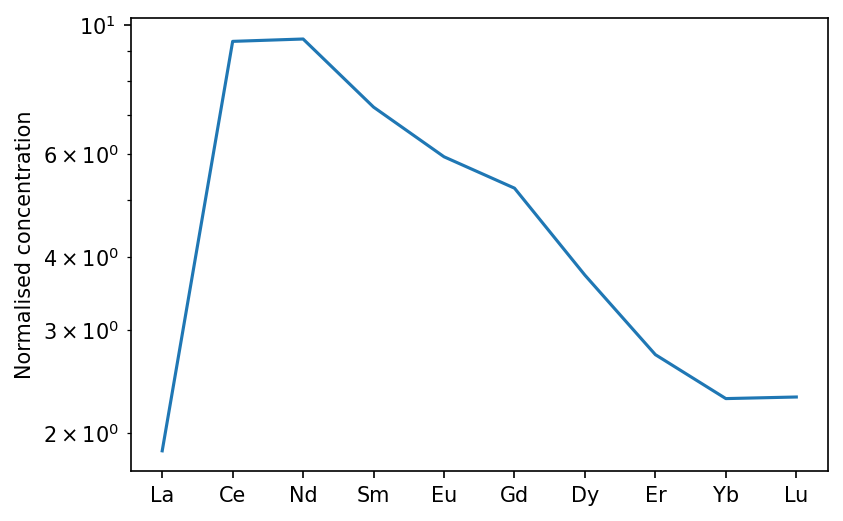

In [131]:
oib_new = m.geosettings.intraPlate(oi_col, 2.5, weightingFunction=m.geosettings.weighting_expdecay, 
                               weighting_wavelength=0.1)
oib_new.plotSpider(element_order=['La','Ce','Nd','Sm','Eu','Gd','Dy','Er','Yb','Lu'])

If we instead wanted to make every element in garnet incompatible, we could pass a single float:

In [132]:
oi_col.calculateChemistry(grt_D = 1e-3,
                           elements = {'lz': m.chemistry.workman05_dmm,
                                       'px': kg1_tes,
                                       'hz': m.chemistry.workman05_dmm}, # Doesn't matter what value
                           cpxExhaustion = {'lz': 0.18,
                                            'px': cpxExhaustion,
                                            'hz': 0.1}, # Doesn't matter what value
                           garnetInCoeffs = {'lz': [666.7, 400.0],
                                             'px': garnetInCoeffs,
                                             'hz': [0,0]},
                           spinelOutCoeffs = {'lz': [666.7, 533.0],
                                              'px': spinelOutCoeffs,
                                              'hz': [0,0]}, # Doesn't matter what value
                           mineralProportions = {'lz': m.chemistry.klb1_MineralProportions,
                                                 'px': m.chemistry.kg1_MineralProportions,
                                                 'hz': m.chemistry.klb1_MineralProportions} # Doesn't matter what value
                          )

(<Figure size 900x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2d2c7e668e0>)

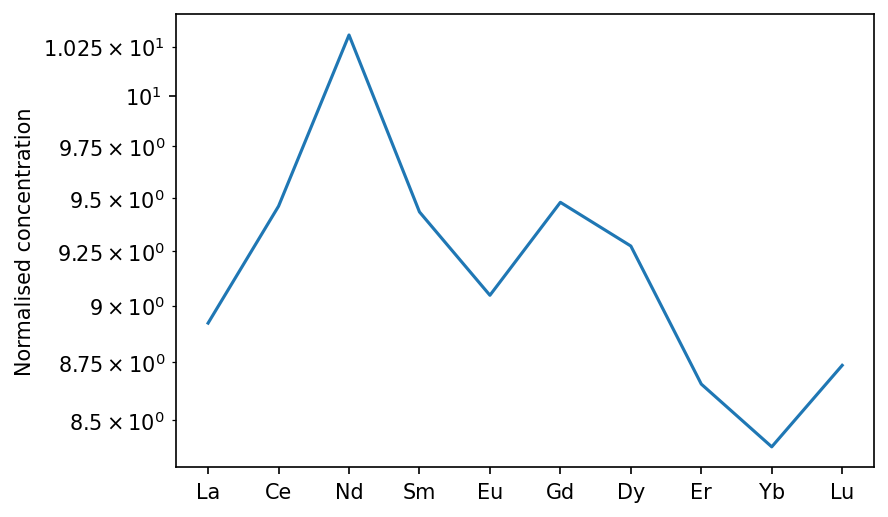

In [133]:
oib_new = m.geosettings.intraPlate(oi_col, 2.5, weightingFunction=m.geosettings.weighting_expdecay, 
                                   weighting_wavelength=0.1)
oib_new.plotSpider(element_order=['La','Ce','Nd','Sm','Eu','Gd','Dy','Er','Yb','Lu'])

This is a somewhat useless and unlikely use case, but universally setting parameters could be useful in other contexts. For example, if using the continuous melting model you might want to set the porosity during melting universally.

## Using a variable partition coefficient
The species objects that are built into pyMelt can incorporate partition coefficients that vary with pressure and temperature (for example). To demonstrate this we can use the partitioning of Na into cpx, which increases substantially with pressure. 

First we have to create a function that takes in pressure. This function approximates the line shown in Figure 9 of Jennings & Holland (2015) for the bulk partition coefficient.

In [134]:
def DNa(state):
    return 0.03*np.exp(state['P']/1.8)

We can demonstrate exactly what this looks like:

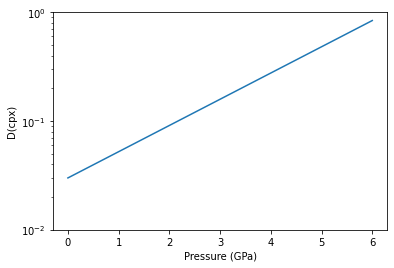

In [135]:
f,a = plt.subplots()

x = np.linspace(0,6,10)
y = np.zeros(np.shape(x))

for i in range(len(x)):
    y[i] = DNa({'P':x[i]})

a.plot(x, y)

a.set_yscale('log')
a.set_ylim(0.01,1)

a.set_xlabel('Pressure (GPa)')
a.set_ylabel('D(cpx)')

plt.show()

This can be passed in a dictionary in place of a numerical value of the partition coefficient, but if we want to calculate just one element it may be faster to create the `species` object directly:

In [136]:
species = m.chemistry.continuousSpecies_instantaneous('Na', 0.13, DNa)

Setting up the problem like this means that the calculations will only be accurate for cpx-present melting. We can see how this affects melts as a function of pressure by iterating through some different mantle temperatures:

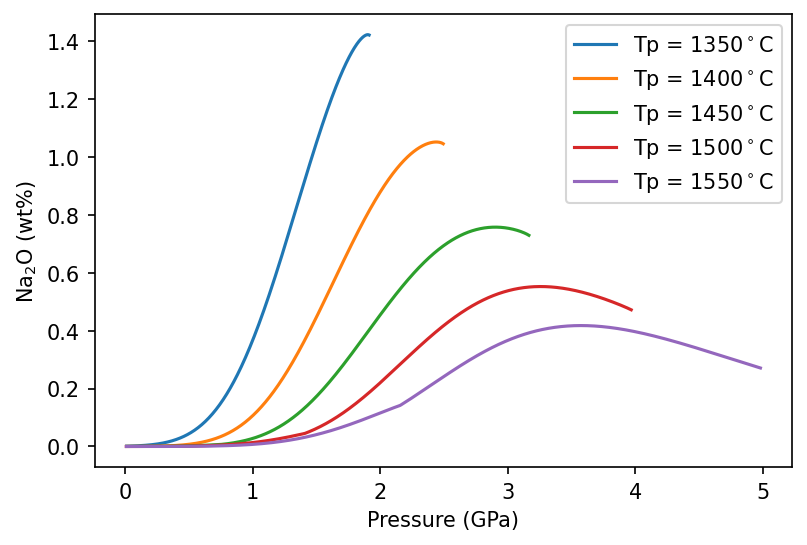

In [137]:
Tps = [1350, 1400, 1450, 1500, 1550]

lz = m.lithologies.matthews.klb1()
mantle = m.mantle([lz], [1.0], ['lz'])

f,a = plt.subplots(dpi=150)

for i in range(len(Tps)):
    column = mantle.adiabaticMelt(Tps[i])
    column.calculateChemistry(species_objects = {'lz' :[species]})
    a.plot(column.P, column.lithologies['lz']['Na'], label='Tp = {:.0f}$^\circ$C'.format(Tps[i]))
    
a.legend()
a.set_xlabel('Pressure (GPa)')
a.set_ylabel('Na$_2$O (wt%)')
    
plt.show()

## References

Jennings, E. S., & Holland, T. J. B. (2015). A Simple Thermodynamic Model for Melting of Peridotite in the System NCFMASOCr. Journal of Petrology, 56(5), 869–892. <https://doi.org/10.1093/petrology/egv020>

McKenzie, D., & O’Nions, R. K. (1991). Partial Melt Distributions from Inversion of Rare Earth Element Concentrations. Journal of Petrology, 32(5), 1021–1091. <https://doi.org/10.1093/petrology/32.5.1021>

Palme, H., & O’Neill, H. St. C. (2014). Cosmochemical Estimates of Mantle Composition. In Treatise on Geochemistry (2nd ed., Vol. 3, pp. 1–39). Elsevier. <https://doi.org/10.1016/B978-0-08-095975-7.00201-1>

Stracke, A., Bizimis, M., & Salters, V. J. M. (2003). Recycling oceanic crust: Quantitative constraints. Geochemistry, Geophysics, Geosystems, 4(3). <https://doi.org/10.1029/2001GC000223>

Workman, R. K., & Hart, S. R. (2005). Major and trace element composition of the depleted MORB mantle (DMM). Earth and Planetary Science Letters, 231(1–2), 53–72. <https://doi.org/10.1016/j.epsl.2004.12.005>
